# Make This Damn Pipeline Work

The goal to start over with something that we know works since something I'm doing doesn't work. This notebook will be broken up into 3 parts

1) Calibrate xx data to GLEAM image cube

2) Calibrate 4-pol data to GLEAM image cube

3) Calibrate 4-pol data to GSM2008 image cube?

python --version
**Python 3.7.1**

ipython --version
**7.3.0**

In [1]:
import numpy as np, matplotlib.pyplot as plt
import pyuvdata.utils as uvutils
import copy
import operator
import subprocess
import os
import sys,shutil
import glob
import yaml
import json
import itertools
import shutil
import re

from pyuvdata import UVData
from datetime import datetime
from collections import OrderedDict as odict
from astropy.time import Time
from functools import reduce

sys.path.insert(0,'/Users/tashaleebillings/')
import casa_imaging
sys.path.insert(0,'/Users/tashaleebillings/casa_imaging/casa_imaging/')
import casa_utils as utils

In [ ]:
for module in ["pyuvdata", "numpy"]:
    try:
        _mdl = import_module(module)
    except ModuleNotFoundError:
        pass
    
    if hasattr(_mdl, 'version'):
        gh = getattr(_mdl.version, 'git_hash', None)
    print("Module {:<11}....\tVersion {:<7}.......\tGit {}".format(module, _mdl.__version__, gh))

# I. Calibrate XX data to GLEAM Image Cube

### Parse YAML File

You have some yaml file with information about different variables that can be read into the notebook.

In [47]:
#-------------------------------------------------------------------------------                                                            
# Parse YAML Configuration File                                                                                                             
#-------------------------------------------------------------------------------                                                            
# Get config and load dictionary                                                                                                            
config = '/Users/tashaleebillings/Desktop/data/NK_CASA_Pipeline/NK_CASA_Calibration_and_Imaging_skycal_params.yaml'
cf = utils.load_config(config)

# Consolidate IO, data and analysis parameter dictionaries                                                                                  
params = odict(list(cf['io'].items()) + list(cf['data'].items()) + list(cf['analysis'].items()))
assert (len(params) == len(cf['io']) + len(cf['data']) + len(cf['analysis'])), "Repeated parameters found within the scope of io, data and analysis dicts"
               
# Get algorithm dictionary                                                                                                                  
algs = cf['algorithm']
datafile = os.path.join(params['data_root'], params['data_file'])

# Get parameters used globally in the pipeline                                                                                              
verbose = params['verbose']
overwrite = params['overwrite']
casa = params['casa'].split() + params['casa_flags'].split()
point_ra = params['point_ra']
longitude = params['longitude']
latitude = params['latitude']
out_dir = params['out_dir']

# Change to working dir                                                                                                                     
nos.chdir(params['work_dir'])

# Open a logfile                                                                                                                            
logfile = os.path.join(out_dir, params['logfile'])
if os.path.exists(logfile) and params['overwrite'] == False:
    raise IOError("logfile {} exists and overwrite == False, quitting pipeline...".format(logfile))
lf = open(logfile, "w")
if params['joinlog']:
    ef = lf
else:
    ef = open(os.path.join(params['out_dir'], params['errfile']), "w")
casa += ['--logfile', logfile]
sys.stdout = lf
sys.stderr = ef

# Setup (Small) Global Variable Dictionary                                                                                                  
varlist = ['datafile', 'verbose', 'overwrite', 'out_dir', 'casa', 'point_ra', 'longitude',
           'latitude', 'lf', 'gaintables']
def global_vars(varlist=[]):
    d = []
    for v in varlist:
        try:
            d.append((v, globals()[v]))
        except KeyError:
            continue
    return dict(d)

# Print out parameter header                                                                                                                
time = datetime.utcnow()
utils.log("Starting skycal_pipe.py on {}\n{}\n".format(time, '-'*60),
             f=lf, verbose=verbose)
_cf = copy.copy(cf)
_cf.pop('algorithm')
utils.log(json.dumps(_cf, indent=1) + '\n', f=lf, verbose=verbose)

# Setup a dict->object converter                                                                                                            
class Dict2Obj:
    def __init__(self, **entries):
        self.__dict__.update(entries)

### Prepare Data to be Converted to Measurment Set

If it is determined that the file(s) are not MS then for each polarization, we loop through each file to see which ones are closest to the correct source LST and then cut the fill down from 10mins to 4mins and then writes it as a new MS file with an updataed JD name.

In [3]:
#-------------------------------------------------------------------------------                                                            
# Search for a Source and Prepare Data for MS Conversion                                                                                    
#-------------------------------------------------------------------------------                                                            
if params['prep_data']:
    # start block                                                                                                                           
    time = datetime.utcnow()
    utils.log("\n{}\n...Starting PREP_DATA: {}\n".format("-"*60, time),
                 f=lf, verbose=verbose)
    utils.log(json.dumps(algs['prep_data'], indent=1) + '\n', f=lf, verbose=verbose)
    p = Dict2Obj(**algs['prep_data'])

    # Check if datafile is already MS
    sys.path.insert(0,'/Users/tashaleebillings/casa_imaging/scripts/')
    import source2file
    
    if os.path.splitext(datafile)[1] in ['.ms','.MS']:
        # get transit times                                                                                                                 
        (lst, transit_jd, utc_range, utc_center, source_files,
         source_utc_range) = source2file.source2file(point_ra, lon=longitude, lat=latitude,
                                                     duration=p.duration, start_jd=p.start_jd, get_filetimes=False,
                                                     verbose=verbose)
        utils.log("...the file {} is already a CASA MS, skipping rest of PREP_DATA".format(datafile), f=lf, verbose=verbose)
        timerange = utc_range

    else:
        # Iterate over polarizations                                                                                                        
        if p.pols is None: p.pols = [None]
        uvds = []
        for pol in p.pols:
            if pol is None:
                pol = ''
            else:
                utils.log("...working on {} polarization".format(pol), f=lf, verbose=verbose)
                pol = '.{}.'.format(pol)

            # glob-parse the data file / template                                                                                           
            datafiles = [df for df in glob.glob(datafile) if pol in df]
            assert len(datafiles) > 0, "Searching for {} with pol {} but found no files...".format(datafile, pol)

            # get transit times                                                                                                             
            import source2file
            (lst, transit_jd, utc_range, utc_center, source_files,
             source_utc_range) = source2file.source2file(point_ra, lon=longitude, lat=latitude,
                                                         duration=p.duration, start_jd=p.start_jd, get_filetimes=p.get_filetimes,
                                                         verbose=verbose, jd_files=copy.copy(datafiles))
            timerange = utc_range

            # ensure source_utc_range and utc_range are similar       
            
            if source_utc_range is not None:
                utc_range_start = utc_range.split('~')[0].strip('"').split('/')
                utc_range_start = map(int, utc_range_start[:-1] + utc_range_start[-1].split(':'))
                utc_range_start = Time(datetime(*utc_range_start), format='datetime').jd
                source_utc_range_start = source_utc_range.split('~')[0].strip('"').split('/')
                source_utc_range_start = map(int, source_utc_range_start[:-1] + source_utc_range_start[-1].split(':'))
                source_utc_range_start = Time(datetime(*source_utc_range_start), format='datetime').jd
                # if difference is larger than 1 minute,                                                                                    
                # then probably the correct files were not found                                                                            
                if np.abs(utc_range_start - source_utc_range_start) * 24 * 60 > 1:
                    utils.log("Warning: Difference between theoretical transit time and transit time " \
                        "deduced from files found is larger than 1-minute: probably the correct " \
                        "files were not found because the correct files did not exist under the " \
                        "data template {}".format(datafile), f=lf, verbose=verbose)
                timerange = source_utc_range

            # load data into UVData         
            utils.log("...loading data", f=lf, verbose=verbose)
            _uvds = []
            for sf in list(source_files):
                # read data                                                                                                                 
                _uvd = UVData()
                _uvd.read(sf, antenna_nums=p.antenna_nums)
                
                # read flagfile if fed                                                                                                      
                if p.flag_ext != "":
                    flagfile = glob.glob("{}{}".format(sf, p.flag_ext))
                    if len(flagfile) == 1:
                        utils.log("...loading and applying flags {}".format(flagfile[0]), f=lf, verbose=verbose)
                        ff = np.load(flagfile[0])
                        _uvd.flag_array += ff['flag_array']

                # append to list                                                                                                            
                _uvds.append(_uvd)

            # concatenate source files                                                                                                      
            uvd = reduce(operator.add, _uvds)

            # isolate only relevant times                                                                                                   
            times = np.unique(uvd.time_array)
            times = times[np.abs(times-transit_jd) < (p.duration / (24. * 60. * 2))]
            assert len(times) > 0, "No times found in source_files {} given transit JD {} and duration {}".format(source_files, transit_jd,\
 p.duration)
            uvd.select(times=times)

            # append                                                                                                                        
            uvds.append(uvd)

        # concatenate uvds                                                                                                                  
        uvd = reduce(operator.add, uvds) #can be issue in python 3

        # get output filepath w/o uvfits extension if provided                                                                              
        outfile = os.path.join(params['out_dir'], p.outfile.format(uvd.time_array.min()))
        if os.path.splitext(outfile)[1] == '.uvfits':
            outfile = os.path.splitext(outfile)[0]

        # renumber antennas (and antenna names!) if above 254                                                                               
        if uvd.antenna_numbers.max() > 254:
            large_ant_nums = sorted(list(uvd.antenna_numbers[np.where(uvd.antenna_numbers > 254)[0]]))
            new_nums = sorted(list(set(range(255)) - set(uvd.antenna_numbers)))
            if len(new_nums) < len(large_ant_nums):
                raise ValueError('too many antennas in dataset, cannot renumber all below 255')
            new_nums = new_nums[-1 * len(large_ant_nums):]
            renumber_dict = dict(list(zip(large_ant_nums, new_nums)))

            history = ''
            name_prefix = os.path.commonprefix(uvd.antenna_names)
            for ant_in, ant_out in renumber_dict.items():
                if verbose:
                    msg = "renumbering {a1} to {a2}".format(a1=ant_in, a2=ant_out)
                    print(msg)
                history += '{}\n'.format(msg)

                wh_ant_num = np.where(uvd.antenna_numbers == ant_in)[0]
                wh_ant1_arr = np.where(uvd.ant_1_array == ant_in)[0]
                wh_ant2_arr = np.where(uvd.ant_2_array == ant_in)[0]

                uvd.antenna_numbers[wh_ant_num] = ant_out
                uvd.antenna_names[wh_ant_num[0]] = "RN{:d}".format(ant_out)
                uvd.ant_1_array[wh_ant1_arr] = ant_out
                uvd.ant_2_array[wh_ant2_arr] = ant_out

            uvd.baseline_array = uvd.antnums_to_baseline(uvd.ant_1_array, uvd.ant_2_array)
            uvd.history = '{}\n{}'.format(history, uvd.history)
            uvd.check()

            # write renumbering dictionary to .npz                                                                                          
            np.savez("{}.renumber.npz".format(outfile),
                     renumber=dict(zip(renumber_dict.values(), renumber_dict.keys())),
                     history="Access dictionary via f['renumber'].item()")

        # write to file                                                                                                                     
        if uvd.phase_type == 'phased':
            # write uvfits                                                                                                                  
            uvfits_outfile = outfile + '.uvfits'
            if not os.path.exists(uvfits_outfile) or overwrite:
                utils.log("...writing {}".format(uvfits_outfile), f=lf, verbose=verbose)
                uvd.write_uvfits(uvfits_outfile, spoof_nonessential=True)
            # unphase to drift                                                                                                              
            uvd.unphase_to_drift()
            # write miriad                                                                                                                  
            if not os.path.exists(outfile) or overwrite:
                utils.log("...writing {}".format(outfile), f=lf, verbose=verbose)
                uvd.write_miriad(outfile, clobber=True)
        elif uvd.phase_type == 'drift':
            # write miriad                                                                                                                  
            if not os.path.exists(outfile) or overwrite:
                utils.log("...writing {}".format(outfile), f=lf, verbose=verbose)
                uvd.write_miriad(outfile, clobber=True)
            # write uvfits                                                                                                                  
            uvfits_outfile = outfile + '.uvfits'
            if not os.path.exists(uvfits_outfile) or overwrite:
                uvd.phase_to_time(Time(transit_jd, format='jd'))
                utils.log("...writing {}".format(uvfits_outfile), f=lf, verbose=verbose)
                uvd.write_uvfits(uvfits_outfile, spoof_nonessential=True)
                
        # convert the uvfits file to ms                                                                                                     
        ms_outfile = outfile + '.ms'
        utils.log("...converting to Measurement Set")
        if not os.path.exists(ms_outfile) or overwrite:
            if os.path.exists(ms_outfile):
                shutil.rmtree(ms_outfile)
            utils.log("...writing {}".format(ms_outfile), f=lf, verbose=verbose)
            ecode = subprocess.check_call(casa + ["-c", "importuvfits('{}', '{}')".format(uvfits_outfile, ms_outfile)])

        # overwrite relevant parameters for downstream analysis                                                                             
        datafile = ms_outfile

        del uvds, uvd

    # overwrite downstream parameters                                                                                                       
    algs['gen_model']['time'] = transit_jd

    # end block                                                                                                                             
    time2 = datetime.utcnow()
    utils.log("...finished PREP_DATA: {:d} sec elapsed".format(utils.get_elapsed_time(time, time2)), f=lf, verbose=verbose)

### Generate Flux Model

This subsection was taken from Nick's pipeline script. "Generate Flux Model" is a section with a couple of functions that help feed in the args params to a CASA python script "complist_gleam.py" that builds the model from the gleam components and saves it as a CASA readable image file ('.image', '.fits').

I decided to not actually run this section. Instead I wanted look more closely at the "complist_gleam.py" script.

In [ ]:
#-------------------------------------------------------------------------------                                                               
# Generate Flux Model                                                                                                                          
#-------------------------------------------------------------------------------                                                               

# Make a Model Generation Function                                                                                                             
def gen_model(**kwargs):
    p = Dict2Obj(**kwargs)
    utils.log("\n{}\n...Generating a Flux Model", f=p.lf, verbose=p.verbose)

    # compile complist_gleam.py command                                                                                                        
    cmd = casa + ["-c", "/Users/tashaleebillings/Desktop/data/NK_CASA_Pipeline/complist_gleam.py"]
    cmd += ['--gleamfile', p.gleamfile,'--point_ra', p.point_ra, '--point_dec', p.latitude, 
            '--outdir', p.out_dir, '--imsize', p.imsize, '--radius', p.radius, 
            '--min_flux', p.min_flux, '--freqs', p.freqs, '--cell', p.cell]
    if p.image:
        cmd += ['--image']
    if p.use_peak:
        cmd += ['--use_peak']
    if p.overwrite:
        cmd += ['--overwrite']
    if hasattr(p, 'regions'):
        cmd += ['--regions', p.regions, '--exclude', '--region_radius', p.region_radius]
    if hasattr(p, 'file_ext'):
        cmd += ['--ext', p.file_ext]
    else:
        p.file_ext = ''
    cmd = map(str, cmd)
    ecode = subprocess.call(cmd)

    modelstem = os.path.join(p.out_dir,"{}_model.cl".format(os.path.basename(p.gleamfile[:-5])))
    model_base = os.path.splitext(modelstem)[0]
    fitsname = "{}.fits".format(model_base)
    if p.image:
        model_base += ".image"

    # pbcorrect                                                                                                                                
    if p.pbcorr:
        utils.log("...applying PB to model", f=p.lf, verbose=p.verbose)
        assert p.image, "Cannot pbcorrect flux model without image == True"
        cmd = ["/Users/tashaleebillings/casa_imaging/scripts/pbcorr.py", "--lon", p.longitude, "--lat", p.latitude, "--time", p.time, "--pols"] \
               + [uvutils.polstr2num(pol) for pol in p.pols] \
               + ["--outdir", p.out_dir, "--multiply", "--beamfile", p.beamfile, "fitsfiles", fitsname]
        if p.overwrite:
            cmd.append("--overwrite")
        #cmd.append(modelstem + '.fits')

        # generate component list and / or image cube flux model                                                                               
        cmd = map(str, cmd)
        ecode = subprocess.call(cmd)
        pbcorr_modelstem = os.path.join(p.out_dir, modelstem)

        # importfits                                                                                                                           
        cmd = p.casa + ["-c", "importfits('{}', '{}', overwrite={})".format(pbcorr_modelstem + '.pbcorr.fits', pbcorr_modelstem + '.pbcorr.image', p.overwrite)]
        ecode = subprocess.call(cmd)
        pbcorr_model = pbcorr_modelstem + ".pbcorr.image"

    return pbcorr_model

if params['gen_model']:
    # start block                                                                                                                              
    time = datetime.utcnow()
    utils.log("\n{}\n...Starting GEN_MODEL: {}\n".format("-"*60, time),
                 f=lf, verbose=verbose)
    utils.log(json.dumps(algs['gen_model'], indent=1) + '\n', f=lf, verbose=verbose)

    # Generate Model                                                                                                                           
    model = gen_model(**dict(list(algs['gen_model'].items()) + list(global_vars(varlist).items())))

    # update di_cal model path                                                                                                                 
    algs['di_cal']['model'] = model

    # end block                                                                                                                                
    time2 = datetime.utcnow()
    utils.log("...finished GEN_MODEL: {:d} sec elapsed".format(utils.get_elapsed_time(time, time2)), f=lf, verbose=verbose)


In [3]:
from astropy.io import fits

In [7]:
small_gleam = fits.open("/Users/tashaleebillings/Desktop/data/small_gleam.fits")

In [10]:
small_gleam[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   73 / length of dimension 1                          
NAXIS2  =               158816 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   10 / number of table fields                         
TTYPE1  = 'GLEAM   '                                                            
TFORM1  = '14A     '                                                            
TDISP1  = 'A14     '                                                            
TTYPE2  = 'RAJ2000 '                                                            
TFORM2  = 'D       '        

In [30]:
(small_gleam[1].data)

FITS_rec([('J210214-503334', 315.56118806, -50.55952806, 0.070516, 0.09502 ,       nan, 0.054038, 0.079292, 8, 2),
          ('J210145-503246', 315.43759194, -50.54626111, 0.065017, 0.075701, -1.070268, 0.051587, 0.062953, 8, 2),
          ('J210443-503427', 316.183075  , -50.57444   , 0.093348, 0.096954, -0.228791, 0.116614, 0.122704, 8, 2),
          ...,
          ('J160542-112733', 241.42691   , -11.45941389, 0.059182, 0.063335, -0.246412, 0.113151, 0.124321, 8, 2),
          ('J163130-104322', 247.87745694, -10.72296194, 0.244387, 0.260097, -0.734114, 0.250608, 0.271932, 8, 2),
          ('J133637-335724', 204.15570111, -33.95689389, 0.035134, 0.031256,       nan, 0.650765, 0.54306 , 8, 2)],
         dtype=(numpy.record, [('GLEAM', 'S14'), ('RAJ2000', '>f8'), ('DEJ2000', '>f8'), ('Fp151', '>f8'), ('Fint151', '>f8'), ('alpha', '>f8'), ('Fpwide', '>f8'), ('Fintwide', '>f8'), ('eabsFpct', '>i2'), ('efitFpct', 'u1')]))

In [21]:
hm = fits.open("/Users/tashaleebillings/Desktop/data/randsrc_airybeam_Nsrc100_fullband_fullStokesModel.model.fits")[0].data
print(type(hm))

<class 'numpy.ndarray'>


In [20]:
bright = np.rec.array([(1,'Sirius', -1.45, 'A1V'),
                       (2,'Canopus', -0.73, 'F0Ib'),
                       (3,'Rigil Kent', -0.1, 'G2V')],
                      formats='int16,a20,float32,a10',
                      names='order,name,mag,Sp')
print(bright)

[(1, b'Sirius', -1.45, b'A1V') (2, b'Canopus', -0.73, b'F0Ib')
 (3, b'Rigil Kent', -0.1 , b'G2V')]


### Build Image Cube From GLEAM Component List

Lets take a closer look at "complist_gleam.py". The first thing I did was print the parameters to the screen. These are the same ones that were originally stored in the yaml file. I'm doing this so that I can manually feed in this information into "complist_gleam.py".

In [96]:
# Print Parameters to screen
gen_model=list(algs['gen_model'].items())
name_gm,values_gm = zip(*gen_model)

global_vars = list(global_vars(varlist).items())
name_gv, values_gv = zip(*global_vars)

names_gmgv = name_gm+name_gv
values_gmgv = values_gm+values_gv

for i in range(len(names_gmgv)):
    print(names_gmgv[i]),
    print('='), 
    print(values_gmgv[i])
    
"""
#in python 3.x
print("geeks", end =" ") 
print("geeksforgeeks") 
"""

### Run "complist_gleam.py" in CASA

Now that I printed the parameters you can copy and paste them below. When you run the cell it will build a CASA image using the componentlist filled with information from GLEAM and then convert it to a fits image file.

In [ ]:
#To be ran in CASA complist_gleam.py
import os, shutil, sys
import numpy as np
import pyfits as fits

gleamfile = '/Users/tashaleebillings/casa_imaging/casa_imaging/data/small_gleam.fits'
point_ra = 30.05
point_dec = -30.7215
outdir = '/Users/tashaleebillings/Desktop/data/NK_CASA_Pipeline/'
image = True
imsize = 512
radius = 20
min_flux = 0.1
use_peak = False
freqs = '100,200,1024'
cell = '300arcsec'
pbcorr = True
beamfile = '/Users/tashaleebillings/casa_imaging/casa_imaging/data/HERA_NF_dipole_power.beamfits'
time = 2458101.294912982
pols = ['xx', 'yy']
datafile = '/Users/tashaleebillings/Desktop/data/NK_CASA_Pipeline/zen.2458101.29385.HH.uvR.ms'
image = True #'True'
overwrite = True
regions = None
region_radius = None

basename = os.path.join(outdir, "{}_model.cl".format(os.path.basename(gleamfile)[:-5]))

if os.path.exists(basename) and not overwrite:
    print("{} already exists, not writing...".format(basename))
    sys.exit()

# set pointing direction
def deg2eq(ra, dec):
    _ra = ra / 15.0
    ra_h = int(np.floor(_ra))
    ra_m = int(np.floor((_ra - ra_h) * 60))
    ra_s = int(np.around(((_ra - ra_h) * 60 - ra_m) * 60))
    dec_d = int(np.floor(np.abs(dec)) * dec / np.abs(dec))
    dec_m = int(np.floor(np.abs(dec - dec_d) * 60.))
    dec_s = int(np.abs(dec - dec_d) * 3600 - dec_m * 60)
    direction = "{:02d}h{:02d}m{:02.0f}s {:03d}d{:02d}m{:02.0f}s".format(ra_h, ra_m, ra_s, dec_d, dec_m, dec_s)
    return direction

direction = "J2000 {}".format(deg2eq(point_ra, point_dec))
ref_freq = "151MHz"

# Select all sources around pointing
hdu = fits.open(gleamfile)
data = hdu[1].data
data_ra = data["RAJ2000"].copy() # 1D array
data_dec = data["DEJ2000"].copy() # 1D array

# get fluxes
if use_peak:
    fstr = "Fp{:d}"
    fluxes = data['Fp151']
else:
    fstr = "Fint{:d}"
    fluxes = data['Fint151']

# correct for wrapping RA
if point_ra < radius:
    data_ra[data_ra > point_ra + radius] -= 360.0
elif np.abs(360.0 - point_ra) < radius:
    data_ra[data_ra < 360.0 - point_ra] += 360.0

# select sources
ra_dist = np.abs(data_ra - point_ra)
dec_dist = np.abs(data_dec - point_dec)
dist = np.sqrt(ra_dist**2 + dec_dist**2)
select = np.where((dist <= radius) & (fluxes >= min_flux))[0]
if len(select) == 0:
    raise ValueError("No sources found given RA, Dec and min_flux selections.")
print("...a total of {} sources were found given RA, Dec and min_flux cuts".format(len(select)))

# if regions provided, load them
if regions is not None:
    mask_ra, mask_dec = np.loadtxt(regions, dtype=np.float, usecols=(2, 3), unpack=True)
    assert region_radius is not None, "if providing a list of sources, must specify region radius [deg]"
    mask_rad = region_radius

# iterate over sources and add to complist
select = select[np.argsort(dist[select])]
source = "{name:s}\t{flux:06.2f}\t{spix:02.2f}\t{ra:07.3f}\t{dec:07.3f}"
sources = []
for s in select:
    # get source info
    flux = fluxes[s]
    spix = data['alpha'][s]
    s_ra, s_dec = data['RAJ2000'][s], data['DEJ2000'][s]
    s_dir = deg2eq(s_ra, s_dec)
    name = "GLEAM {}".format(s_dir)

    # exclude or include if fed regions
    if regions is not None:
        mask_dists = np.sqrt((mask_ra - s_ra)**2 + (mask_dec - s_dec)**2)
        if a.exclude:
            if mask_dists.min() < mask_rad:
                continue
        else:
            if mask_dists.min() >= mask_rad:
                continue

    # if spectral index is a nan, try to derive it by hand
    if np.isnan(spix):
        frq = np.array([122., 130., 143., 151., 158., 166., 174.])
        x = []
        xstr = []
        for f in frq:
            xst = fstr.format(int(f))
            if xst in data.dtype.fields:
                x.append(f)
                xstr.append(xst) # a list of peak or integration names
        x = np.asarray(x, dtype=np.float)# array of frq
        y = np.log10([data[s][xs] for xs in xstr])
        if sum(~np.isnan(y)) < 2:
            # skip this source b/c less all but 1 bins are negative or nan...
            continue
        spix = np.polyfit(np.log10(x)[~np.isnan(y)], y[~np.isnan(y)], deg=1)[0]# returns coeff.

        # if this is unreasonable, set to 0
        if spix < -3 or spix > 1:
            spix = 0

    # create component list
    cl.addcomponent(label=name, flux=flux, fluxunit="Jy",
                    dir="J2000 {}".format(s_dir), freq=ref_freq, shape='point',
                    spectrumtype='spectral index', index=spix)
    sources.append(source.format(name=name, flux=flux, spix=spix, ra=s_ra, dec=s_dec))

# write source list to file
print("...including {} sources".format(len(sources)))
srcname = "{}.srcs.tab".format(basename)
print("...saving {}".format(srcname))
with open(srcname, "w") as f:
    f.write("# name\t flux [Jy]\t spix\t RA\t Dec\n")
    f.write('\n'.join(sources))

# save
print("...saving {}".format(basename))
if os.path.exists(basename):
    shutil.rmtree(basename)
cl.rename(basename)

# make image
if image:
    print("Making image.")
    # get frequencies
    if freqs is None:
        Nfreqs = 1
        freq = np.array([151.0])
    else:
        freq = np.linspace(*np.array(freqs.split(',')).astype(np.float), endpoint=False)
        Nfreqs = len(freq)

    # setup image
    imname = "{}.image".format(basename)
    print("...saving {}".format(imname))
    ia.fromshape(imname, [imsize, imsize, 1, Nfreqs], overwrite=True)
    cs = ia.coordsys()
    cs.setunits(['rad','rad','','Hz'])

    # set pixel properties
    cell_rad = qa.convert(qa.quantity(cell),"rad")['value']
    cs.setincrement([-cell_rad, cell_rad], type='direction')
    cs.setreferencevalue([qa.convert(direction.split()[1],'rad')['value'], qa.convert(direction.split()[2],'rad')['value']], type="direction")

    # set freq properties
    qa_freqs = qa.quantity(freq, 'MHz')
    cs.setspectral(frequencies=qa_freqs)

    # set flux properties, make image, export to fits
    ia.setcoordsys(cs.torecord())
    ia.setbrightnessunit("Jy/pixel")
    ia.modify(cl.torecord(), subtract=False)
    fitsname = "{}.fits".format(basename)
    print("...saving {}".format(fitsname))
    exportfits(imagename=imname, fitsimage=fitsname, overwrite=True, stokeslast=False)

cl.close()


### Primary Beam Correction

Now we need to primary beam correct the model. You can run pbcorr.py but here I copied the script below and used the appropriate parameters from the yaml file.

In [145]:
# Primary beam correct out model.
import numpy as np
import astropy.io.fits as fits
import scipy.stats as stats
import os, sys, glob, copy, shutil, healpy

from astropy import wcs
from pyuvdata import UVBeam
from scipy import interpolate
from astropy.time import Time
from astropy import coordinates as crd
from astropy import units as u


beamfile = '/Users/tashaleebillings/casa_imaging/casa_imaging/data/HERA_NF_dipole_power.beamfits'
fitsfiles = ['/Users/tashaleebillings/Desktop/data/NK_CASA_Pipeline/small_gleam_model.cl.fits']
outdir = '/Users/tashaleebillings/Desktop/data/NK_CASA_Pipeline/'
ext = None
pols = [uvutils.polstr2num(pol) for pol in p.pols]
overwrite = True
multiply = True
lon_t = 21.4286
lat_t = -30.7215
time_ = 2458101.294912982

# load pb
if beamfile is not None:
    print("...loading beamfile {}".format(beamfile))
    # load beam
    uvb = UVBeam()
    uvb.read_beamfits(beamfile)
    # get beam models and beam parameters
    beam_maps = np.abs(uvb.data_array[0, 0, :, :, :])
    beam_freqs = uvb.freq_array.squeeze() / 1e6
    Nbeam_freqs = len(beam_freqs)
    beam_nside = healpy.npix2nside(beam_maps.shape[2])

    # construct beam interpolation function
    def beam_interp_func(theta, phi):
        # convert to radians
        theta = copy.copy(theta) * np.pi / 180.0
        phi = copy.copy(phi) * np.pi / 180.0
        shape = theta.shape
        # loop over freq, then pol
        beam_interp = [[healpy.get_interp_val(m, theta.ravel(), phi.ravel(), lonlat=False).reshape(shape) for m in maps] for maps in beam_maps]
        return np.array(beam_interp)

# construct pb
else: # doesn't matter because we are giving this script a beamfile
    # construct beam interpolation function
    print("...constructing beam from Gaussian models")
    if ew_sig is None or ns_sig is None:
        raise AttributeError("if beamfile is None, then must feed ew_sig and ns_sig")
    def beam_interp_func(theta, phi):
        beam_interp = []
        psi_ew = theta * np.cos(phi)
        psi_ns = theta * np.sin(phi)
        shape = theta.shape
        for i, (ews, nss) in enumerate(zip(ew_sig, ns_sig)):
            m = stats.multivariate_normal.pdf(np.array([psi_ew.ravel(), psi_ns.ravel()]).T, mean=np.zeros(2),
                                          cov=np.array([[ews**2, 0],[0, nss**2]]))
            beam_interp.append(m.reshape(shape))
        return np.array(beam_interp)
    beam_freqs = np.array(gauss_freqs) / 1e6

# iterate over FITS files
for i, ffile in enumerate(fitsfiles):

    # create output filename
    if outdir is None:
        output_dir = os.path.dirname(ffile)
    else:
        output_dir = outdir

    output_fname = os.path.basename(ffile)
    output_fname = os.path.splitext(output_fname)
    if ext is not None:
        output_fname = output_fname[0] + '.pbcorr{}'.format(ext) + output_fname[1]
    else:
        output_fname = output_fname[0] + '.pbcorr' + output_fname[1]
    output_fname = os.path.join(output_dir, output_fname)

    # check for overwrite
    if os.path.exists(output_fname) and overwrite is False:
        raise IOError("{} exists, not overwriting".format(output_fname))

    # load hdu
    print("...loading {}".format(ffile))
    hdu = fits.open(ffile)

    # get header and data
    head = hdu[0].header
    data = hdu[0].data

    # determine if freq precedes stokes in header
    if head['CTYPE3'] == 'FREQ':
        freq_ax = 3
        stok_ax = 4
    else:
        freq_ax = 4
        stok_ax = 3

    # get axes info
    npix1 = head["NAXIS1"]
    npix2 = head["NAXIS2"]
    nstok = head["NAXIS{}".format(stok_ax)]
    nfreq = head["NAXIS{}".format(freq_ax)]

    # get polarization info
    pol_arr = np.asarray(head["CRVAL{}".format(stok_ax)] + np.arange(nstok) * head["CDELT{}".format(stok_ax)], dtype=np.int)

    # replace with forced polarization if provided
    if pols is not None:
        pol_arr = np.asarray(pols, dtype=np.int)

    # set beam maps
    beam_pols = uvb.polarization_array.tolist()
    beam_maps = np.array([beam_maps[beam_pols.index(p)] for p in pol_arr])

    # make sure required pols exist in maps
    if not np.all([p in uvb.polarization_array for p in pol_arr]):
        raise ValueError("Required polarizationns {} not found in Beam polarization array".format(pol_arr))

    # get WCS
    w = wcs.WCS(ffile)

    # convert pixel to equatorial coordinates
    lon_arr, lat_arr = np.meshgrid(np.arange(npix1), np.arange(npix2))
    lon, lat, s, f = w.all_pix2world(lon_arr.ravel(), lat_arr.ravel(), 0, 0, 0)
    lon = lon.reshape(npix2, npix1)
    lat = lat.reshape(npix2, npix1)

    # convert from equatorial to spherical coordinates
    loc = crd.EarthLocation(lat=lat_t*u.degree, lon=lon_t*u.degree)
    time = Time(time_, format='jd', scale='utc')
    equatorial = crd.SkyCoord(ra=lon*u.degree, dec=lat*u.degree, frame='fk5', location=loc, obstime=time)
    altaz = equatorial.transform_to('altaz')
    theta = np.abs(altaz.alt.value - 90.0)
    phi = altaz.az.value

    # get data frequencies
    if freq_ax == 3:
        data_freqs = w.all_pix2world(0, 0, np.arange(nfreq), 0, 0)[2] / 1e6
    else:
        data_freqs = w.all_pix2world(0, 0, 0, np.arange(nfreq), 0)[3] / 1e6
    Ndata_freqs = len(data_freqs)

    if i == 0 or a.spec_cube is False:
        # evaluate primary beam
        print("...evaluating PB")
        pb = beam_interp_func(theta, phi)

    # interpolate primary beam onto data frequencies
    print("...interpolating PB")
    pb_shape = (pb.shape[1], pb.shape[2])
    pb_interp = interpolate.interp1d(beam_freqs, pb, axis=1, kind='linear', fill_value='extrapolate')(data_freqs)

    # data shape is [naxis4, naxis3, naxis2, naxis1]
    if freq_ax == 4:
        pb_interp = np.moveaxis(pb_interp, 0, 1)

    # divide or multiply by primary beam
    if multiply is True:
        print("...multiplying PB into image")
        data_pbcorr = data * pb_interp
    else:
        print("...dividing PB into image")
        data_pbcorr = data / pb_interp

    # change polarization to interpolated beam pols
    head["CRVAL{}".format(stok_ax)] = pol_arr[0]
    if len(pol_arr) == 1:
        step = 1
    else:
        step = np.diff(pol_arr)[0]
    head["CDELT{}".format(stok_ax)] = step
    head["NAXIS{}".format(stok_ax)] = len(pol_arr)

    print("...saving {}".format(output_fname))
    fits.writeto(output_fname, data_pbcorr, head, overwrite=True)

    output_pb = output_fname.replace(".pbcorr.", ".pb.")
    print("...saving {}".format(output_pb))
    fits.writeto(output_pb, pb_interp, head, overwrite=True)


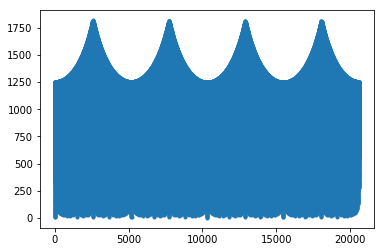

In [147]:
# make sure theta and phi make sense
plt.figure()
plt.plot(np.degrees(phi.flatten()),np.degrees(theta.flatten()),'.')
plt.show()

In [150]:
# importfits                                                                                                                           
cmd = p.casa + ["-c", "importfits('{}', '{}', overwrite={})".format(output_fname, os.path.splitext(output_fname)[0] + '.image', p.overwrite)]
ecode = subprocess.call(cmd)

### Calibration

To be ran in CASA

In [12]:
# Print perameters
cal_kwargs = copy.deepcopy(dict(list(algs['gen_cal'].items()) + list(algs['di_cal'].items())))
kwargs = global_vars(varlist)
kwargs.update(cal_kwargs)
kwargs = dict(list(cal_kwargs.items()) + list(global_vars(varlist).items()))
print(kwargs)

In [13]:
kwargs

{'source': 'gleam02',
 'source_ra': 30.05,
 'source_dec': -30.891,
 'ex_ants': '0,2,11,14,50,98',
 'export_gains': True,
 'smooth': True,
 'gp_max_dly': 200,
 'medfilt': True,
 'kernel': 13,
 'bp_broad_flags': True,
 'bp_flag_frac': 0.25,
 'model': 'small_gleam.cl.pbcorr.image',
 'refant': 53,
 'rflag': False,
 'KGcal': True,
 'KGsnr': 0.0,
 'Acal': True,
 'Asnr': 0.0,
 'BPcal': True,
 'BPsnr': 0.0,
 'BPsolnorm': False,
 'uvrange': '',
 'timerange': '',
 'gain_spw': '',
 'bp_spw': '',
 'split_cal': False,
 'split_ext': 'split',
 'split_model': True,
 'gain_ext': '',
 'gaintables': '',
 'datafile': '/Users/tashaleebillings/Desktop/data/NK_CASA_Pipeline/zen.2458042.45466.HH.uvR.ms',
 'verbose': True,
 'overwrite': True,
 'out_dir': '/Users/tashaleebillings/Desktop/data/NK_CASA_Pipeline/',
 'casa': ['casa',
  '--nologger',
  '--nocrashreport',
  '--nogui',
  '--agg',
  '--logfile',
  '/Users/tashaleebillings/Desktop/data/NK_CASA_Pipeline/skycal_out.log'],
 'point_ra': 30.05,
 'longitude':

In [17]:
#-------------------------------------------------------------------------------
# Expand sky_cal.py
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# Calibration and Imaging Functions
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# Direction Independent Calibration
#-------------------------------------------------------------------------------
import sys
import os
import numpy as np
import argparse
import subprocess
import shutil
import glob
import re

Acal = True
Asnr = 0.0
BPcal = True
BPsnr = 0.0
BPsolnorm = False
KGcal = True
KGsnr = 0.0
bp_broad_flags = True
bp_flag_frac = 0.25
bp_spw = ''
datafile = ms_outfile#'/Users/tashaleebillings/Desktop/data/NK_CASA_Pipeline/zen.2458042.45466.HH.uvR.ms'
ex_ants = '0,2,11,14,50,98'
export_gains = True
gain_ext = ''
gain_spw = ''
gaintables = ''
gp_max_dly = 200
kernel = 13
latitude = -30.7215
#lf = <open file '/Users/tashaleebillings/Desktop/data/NK_CASA_Pipeline/skycal_out.log', mode 'w' at 0x11b58bd20>
longitude = 21.4286
medfilt = True
model = '/Users/tashaleebillings/Desktop/data/NK_CASA_Pipeline/small_gleam_model.cl.pbcorr.image'
out_dir = '/Users/tashaleebillings/Desktop/data/NK_CASA_Pipeline/'
overwrite = True
point_ra = 30.05
refant = '53'
rflag = True
smooth = True
source = 'gleam02'
source_dec = -30.891
source_ra = 30.05
split_cal = False
split_ext = 'split'
split_model = True
timerange = ''
uvrange = ''
verbose = True
msin= ms_outfile#'/Users/tashaleebillings/Desktop/data/NK_CASA_Pipeline/zen.2458042.45466.HH.uvR.ms'
silence=False
unflag=False
bpoly=False
degamp=4
degphase=1
flag_autos=False
cal_ext="split"
model_ext="model"
gaintables=[]

In [ ]:
def echo(message, type=0):
    if verbose:
        if type == 0:
            print(message)
        elif type == 1:
            print("\n" + message + "\n" + "-"*40)

# get phase center
if source_ra is not None and source_dec is not None:
    _ra = source_ra / 15.0
    ra_h = int(np.floor(_ra))
    ra_m = int(np.floor((_ra - ra_h) * 60.))
    ra_s = int(np.around(((_ra - ra_h) * 60. - ra_m) * 60.))
    dec_d = int(np.floor(np.abs(source_dec)) * source_dec / np.abs(source_dec))
    dec_m = int(np.floor(np.abs(source_dec - dec_d) * 60.))
    dec_s = int(np.abs(source_dec - dec_d) * 3600. - dec_m * 60.)
    fixdir = "J2000 {:02d}h{:02d}m{:02.0f}s {:03d}d{:02d}m{:02.0f}s".format(ra_h, ra_m, ra_s, dec_d, dec_m, dec_s)
else:
    fixdir = None

#msin = msin

# get paths
base_ms = os.path.basename(msin)
if out_dir is None:
    out_dir = os.path.dirname(msin)
else:
    out_dir = out_dir

# check for uvfits
if base_ms.split('.')[-1] == 'uvfits':
    echo("...converting uvfits to ms", type=1)
    uvfits = msin
    msin = os.path.join(out_dir, '.'.join(base_ms.split('.')[:-1] + ['ms']))
    base_ms = os.path.basename(msin)
    msfiles = glob.glob("{}*".format(msin))
    if len(msfiles) != 0:
        for i, msf in enumerate(msfiles):
            try:
                os.remove(msf)
            except OSError:
                shutil.rmtree(msf)
    echo("writing {}".format(msin))
    importuvfits(uvfits, msin)

# get antenna name to station mapping
tb.open("{}/ANTENNA".format(msin))
antstn = tb.getcol("STATION")
tb.close()
antstn = [stn for stn in antstn if stn != '']
antids = [re.findall('\d+', stn)[0] for stn in antstn]
antid2stn = dict(zip(antids, antstn))

# configure refant
if refant is None and (KGcal is True or Acal is True or BPcal is True):
    raise AttributeError("if calibrating, refant needs to be specified")
if refant is not None:
    refants = [antid2stn[ra] for ra in refant.split(',') if ra in antid2stn]

# rephase to source
if fixdir is not None:
    echo("...fix vis to {}".format(fixdir), type=1)
    fixvis(msin, msin, phasecenter=fixdir)

# insert source model
if model is None:
    if KGcal is True or Acal is True or BPcal is True:
        print("...Warning: Asking to calibrate but no model image or component list provided.")
else:
    if os.path.splitext(model)[1] == '.cl':
        echo("...inserting component list {} as MODEL".format(model), type=1)
        ft(msin, complist=model, usescratch=True)
    else:
        echo("...inserting image {} as MODEL".format(model), type=1)
        ft(msin, model=model, usescratch=True)

# unflag
if unflag is True:
    echo("...unflagging", type=1)
    flagdata(msin, mode='unflag')

# flag autocorrs
if flag_autos:
    echo("...flagging autocorrs", type=1)
    flagdata(msin, autocorr=True)

# flag bad ants
if ex_ants is not None:
    ex_ants = ','.join([antid2stn[xa] for xa in ex_ants.split(',') if xa in antid2stn])
    echo("...flagging bad ants: {}".format(ex_ants), type=1)
    flagdata(msin, mode='manual', antenna=ex_ants)

# rflag
if rflag is True:
    echo("...rfi flagging", type=1)
    flagdata(msin, mode='rflag')

def make_cal(cal):
    if gain_ext != '':
        c = os.path.join(out_dir, '.'.join([base_ms, gain_ext, '{}.cal'.format(cal)]))
    else:
        c = os.path.join(out_dir, '.'.join([base_ms, '{}.cal'.format(cal)]))
    return c

def KGCAL(msin, gaintables=[]):
    ## perform per-antenna delay and phase calibration ##
    # setup calibration tables    
    kc = make_cal('K')
    gpc = make_cal('Gphs') 

    # perform initial K calibration (per-antenna delay)
    echo("...performing K gaincal", type=1)
    if os.path.exists(kc):
        shutil.rmtree(kc)
    if os.path.exists("{}.png".format(kc)):
        os.remove("{}.png".format(kc))
    # iterate calibration over refants
    for ra in refants:
        gaincal(msin, caltable=kc+'_{}'.format(ra), gaintype="K", solint='inf', refant=ra, minsnr=KGsnr,
                spw=gain_spw, gaintable=gaintables, timerange=cal_timerange, uvrange=uvrange)
    # merge delay solutions
    kc_files = sorted(glob.glob("{}_*".format(kc)))
    for i, kcf in enumerate(kc_files):
        tb.open(kcf)
        if i == 0:
            delays = tb.getcol('FPARAM')
            delay_ants = tb.getcol('ANTENNA1')
            delay_flags = tb.getcol('FLAG')
            delay_wgts = (~delay_flags).astype(np.float)
        else:
            dlys = tb.getcol('FPARAM')
            dly_ants = tb.getcol('ANTENNA1')
            flgs = tb.getcol('FLAG')
            wgts = (~flgs).astype(np.float)

            delays = (delays*delay_wgts + dlys*wgts) / (delay_wgts + wgts).clip(1e-10, np.inf)
            delay_flags = delay_flags * flgs
            delay_wgts = (~delay_flags).astype(np.float)
        tb.close()
    shutil.copytree(kc_files[0], kc)
    tb.open(kc, nomodify=False)
    tb.putcol("FPARAM", delays)
    tb.putcol("FLAG", delay_flags)
    tb.close()
    for kcf in kc_files:
        shutil.rmtree(kcf)
    # plot cal
    plotcal(kc, xaxis='antenna', yaxis='delay', figfile='{}.png'.format(kc), showgui=False)
    # append to gaintables
    gaintables.append(kc)
    # write delays as npz file
    tb.open(kc)
    delays = tb.getcol('FPARAM')
    delay_ants = tb.getcol('ANTENNA1')
    delay_flags = tb.getcol('FLAG')
    tb.close()
    np.savez("{}.npz".format(kc), delay_ants=delay_ants, delays=delays, delay_flags=delay_flags, shape='(Npol, Nfreq, Nant)')
    echo("...Solved for {} antenna delays".format(np.sum(~delay_flags)))
    echo("...Saving delays to {}.npz".format(kc))
    echo("...Saving plotcal to {}.png".format(kc))

    # perform initial G calibration for phase (per-spw and per-pol gain)
    echo("...performing G gaincal for phase", type=1)
    if os.path.exists(gpc):
        shutil.rmtree(gpc)
    if os.path.exists("{}.png".format(gpc)):
        os.remove("{}.png".format(gpc))
    gaincal(msin, caltable=gpc, gaintype='G', solint='inf', refant=refant, minsnr=KGsnr, calmode='p',
            spw=gain_spw, gaintable=gaintables, timerange=cal_timerange, uvrange=uvrange)
    plotcal(gpc, xaxis='antenna', yaxis='phase', figfile='{}.png'.format(gpc), showgui=False)
    gaintables.append(gpc)

    # write phase to file
    tb.open(gpc)
    phases = np.angle(tb.getcol('CPARAM'))
    phase_ants = tb.getcol('ANTENNA1')
    phase_flags = tb.getcol('FLAG')
    tb.close()
    np.savez("{}.npz".format(gpc), phase_ants=phase_ants, phases=phases, phase_flags=phase_flags, shape='(Npol, Nfreq, Nant)')
    echo("...Solved for {} antenna phases".format(np.sum(~phase_flags)))
    echo("...Saving phases to {}.npz".format(gpc))
    echo("...Saving plotcal to {}.png".format(gpc))

    return gaintables

def ACAL(msin, gaintables=[]):
    # gaincal G amplitude
    echo("...performing G gaincal for amplitude", type=1)
    gac = make_cal("Gamp")

    if os.path.exists(gac):
        shutil.rmtree(gac)
    if os.path.exists("{}.png".format(gac)):
        os.remove("{}.png".format(gac))
    gaincal(msin, caltable=gac, gaintype='G', solint='inf', refant=refant, minsnr=Asnr, calmode='a',
            spw=gain_spw, gaintable=gaintables, timerange=cal_timerange, uvrange=uvrange)
    plotcal(gac, xaxis='antenna', yaxis='amp', figfile='{}.png'.format(gac), showgui=False)
    gaintables.append(gac)

    # write amp to file
    tb.open(gac)
    amps = np.abs(tb.getcol('CPARAM'))
    amp_ants = tb.getcol('ANTENNA1')
    amp_flags = tb.getcol('FLAG')
    tb.close()
    np.savez("{}.npz".format(gac), amp_ants=amp_ants, amps=amps, amp_flags=amp_flags, shape='(Npol, Nfreq, Nant)')
    echo("...Solved for {} antenna amps".format(np.sum(~amp_flags)))
    echo("...Saving amps to {}.npz".format(gac))
    echo('...Saving G amp plotcal to {}.png'.format(gac))

    return gaintables

def BPCAL(msin, gaintables=[]):
    # calibrated bandpass
    echo("...performing B bandpass cal", type=1)
    bc = make_cal("B")

    Btype = "B"
    if bpoly:
        Btype="BPOLY"
    if os.path.exists(bc):
        shutil.rmtree(bc)
    if os.path.exists("{}.amp.png".format(bc)):
        os.remove("{}.amp.png".format(bc))
    if os.path.exists("{}.phs.png".format(bc)):
        os.remove("{}.phs.png".format(bc))
    bandpass(vis=msin, spw=bp_spw, minsnr=BPsnr, bandtype=Btype, degamp=degamp, degphase=degphase,
            caltable=bc, gaintable=gaintables, solint='inf', refant=refant, timerange=cal_timerange,
            uvrange=uvrange, solnorm=BPsolnorm)
    plotcal(bc, xaxis='chan', yaxis='amp', figfile="{}.amp.png".format(bc), showgui=False)
    plotcal(bc, xaxis='chan', yaxis='phase', figfile="{}.phs.png".format(bc), showgui=False)
    gaintables.append(bc)

    # write bp to file
    if bpoly is False:
        # get flags and bandpass data
        tb.open(bc)
        bp = tb.getcol('CPARAM')
        bp_ants = tb.getcol("ANTENNA1")
        bp_flags = tb.getcol('FLAG')
        tb.close()
        # load spectral window data
        tb.open(bc+"/SPECTRAL_WINDOW")
        bp_freqs = tb.getcol("CHAN_FREQ")
        tb.close()
        # write to file
        np.savez("{}.npz".format(bc), bp=bp, bp_ants=bp_ants, bp_flags=bp_flags, bp_freqs=bp_freqs, shape='(Npol, Nfreq, Nant)')
        echo("...Solved for {} antenna bandpasses".format(np.sum(~bp_flags)))
        echo("...Saving bandpass to {}.npz".format(bc))
        echo("...Saving amp plotcal to {}.amp.png".format(bc))
        echo("...Saving phs plotcal to {}.phs.png".format(bc))
    else:
        echo("NOTE: Writing BPOLY bandpass solutions to .npz file not currently supported.")

    return gaintables

## Begin Calibration ##
# init cal_timerange
cal_timerange = ','.join(timerange)

# run through various calibration options
#gaintables = gaintables
if KGcal:
    gaintables = KGCAL(msin, gaintables)

if Acal:
    gaintables = ACAL(msin, gaintables)

if BPcal:
    gaintables = BPCAL(msin, gaintables)

# apply calibration gaintables
if len(gaintables) > 0:
    echo("...applying gaintables: \n {}".format('\n'.join(gaintables)), type=1)
    applycal(msin, gaintable=gaintables)

    # split cal
    if split_cal:
        # split MS
        ms_split = os.path.join(out_dir, "{}.{}".format(base_ms, cal_ext))
        files = glob.glob("{}*".format(ms_split))
        for f in files:
            if os.path.exists(f):
                try:
                    shutil.rmtree(f)
                except OSError:
                    os.remove(f)

        echo("...splitting CORRECTED of {} into {}".format(msin, ms_split))
        split(msin, ms_split, datacolumn="corrected")
else:
    echo("...no calibration performed", type=1)

if split_model:
    # split MS
    ms_split = os.path.join(out_dir, "{}.{}".format(base_ms, model_ext))
    files = glob.glob("{}*".format(ms_split))
    for f in files:
        if os.path.exists(f):
            try:
                shutil.rmtree(f)
            except OSError:
                os.remove(f)
    echo("...splitting MODEL of {} into {}".format(msin, ms_split))
    split(msin, ms_split, datacolumn="model")

In [14]:
# end block
time2 = datetime.utcnow()
utils.log("...finished DI_CAL: {:d} sec elapsed".format(utils.get_elapsed_time(time, time2)), f=lf, verbose=verbose)

In [26]:
# Gather gaintables
gext = ''
if gain_ext not in ['', None]:
    gext = '.{}'.format(gain_ext)
gts = sorted(glob.glob("{}{}.?.cal".format(datafile, gext)) + glob.glob("{}{}.????.cal".format(datafile, gext)))

utils.log("...exporting\n{}\n to calfits and combining into a single cal table".format('\n'.join(gts)), f=lf, verbose=verbose)
# do file checks
mirvis = os.path.splitext(datafile)[0]
gtsnpz = ["{}.npz".format(gt) for gt in gts]

###  EXPORT TO CALFITS

Simply run the cell below.

In [74]:
# export to calfits if desired
if not os.path.exists(mirvis):
    utils.log("...{} doesn't exist: cannot export gains to calfits".format(mirvis), f=lf, verbose=verbose)

elif len(gts) == 0:
    utils.log("...no gaintables found, cannot export gains to calfits", f=lf, verbose=verbose)

elif not np.all([os.path.exists(gtnpz) for gtnpz in gtsnpz]):
    utils.log("...couldn't find a .npz file for all input .cal tables, can't export to calfits", f=lf, verbose=verbose)

else:
    calfits_fname = "{}.{}{}.calfits".format(os.path.basename(mirvis), source, gain_ext)
    cmd = ['python','/Users/tashaleebillings/casa_imaging/scripts/skynpz2calfits.py', "--fname", calfits_fname, "--uv_file", mirvis, '--out_dir', out_dir]
    if overwrite:
        cmd += ["--overwrite"]
    # add a delay and phase solution
    matchK = ["K.cal.npz" in gt for gt in gtsnpz]
    matchGphs = ["Gphs.cal.npz" in gt for gt in gtsnpz]
    if np.any(matchK):
        cmd += ["--plot_dlys"]
        cmd += ["--dly_files"] + [gtsnpz[i] for i, b in enumerate(matchK) if b == True]
        if not np.any(matchGphs):
            utils.log("...WARNING: A delay file {} was found, but no mean phase file, which is needed if a delay file is present.", f=lf, verbose=verbose)
    if np.any(matchGphs):
        cmd += ["--plot_phs"]
        cmd += ["--phs_files"] + [gtsnpz[i] for i, b in enumerate(matchGphs) if b == True]

    # add a mean amp solution
    matchGamp = ["Gamp.cal.npz" in gt for gt in gtsnpz]
    if np.any(matchGamp):
        cmd += ["--plot_amp"]
        cmd += ["--amp_files"] + [gtsnpz[i] for i, b in enumerate(matchGamp) if b == True]

    # add a bandpass solution
    matchB = ["B.cal.npz" in gt for gt in gtsnpz]
    if np.any(matchB):
        cmd += ["--plot_bp"]
        cmd += ["--bp_files"] + [gtsnpz[i] for i, b in enumerate(matchB) if b == True]

    # additional smoothing options
    if smooth:
        cmd += ["--bp_gp_smooth", "--bp_gp_max_dly", gp_max_dly]
    if medfilt:
        cmd += ["--bp_medfilt", "--medfilt_kernel", kernel]
    if bp_broad_flags:
        cmd += ["--bp_broad_flags", "--bp_flag_frac", bp_flag_frac]
    if not verbose:
        cmd += ['--silence']

    cmd = map(str, cmd)
    ecode = subprocess.call(cmd)

### Convert CALFITS Back to Btotal.cal

I directly ran "calfits_to_Bcal.py" in CASA to convert the new calibration solutions from NPZ format to calfits format.

In [ ]:
# convert calfits back to a single Btotal.cal table
# Run with casa as: casa -c calfits_to_Bcal.py <args>
import pyfits
import os
import shutil
import numpy as np

# Set Arguments
bfile_ = gts[matchB.index(True)]
btot_file_ = os.path.join(out_dir, "{}{}.Btotal.cal".format(os.path.basename(datafile), gext))
cfits_ = os.path.join(out_dir, calfits_fname)
inp_cfile_ = bfile
out_cfile_ = btot_file
overwrite_ = True


def calfits_to_Bcal(cfits, inp_cfile, out_cfile=None, overwrite=False):
    """
    Take a calfits antenna gain file and insert data into an existing
    CASA bandpass calibration table. Note that due to the obtuseness of CASA,
    this function is VERY rigid: the calfits file must be very similar in shape
    and order to the CASA Bcal table.
    It is only recommended to use this script on calfits files that were originally
    *B.cal tables, exported to B.cal.npz files by sky_cal.py and then converted to
    calfits via skynpz2calfits.py.
    Args:
        cfits : str, filepath to pyuvdata calfits file
        inp_cfile : str, filepath to CASA Bandpass calibration table to use as a template
        out_cfile : str, filepath for output CASA Bcal table with cfits data
        overwrite : bool, if True, overwrite output Bcal table
    """
    # assert IO
    if out_cfile is None:
        out_cfile = inp_cfile        
    if os.path.exists(out_cfile) and not overwrite:
        raise IOError("Output cal table {} exists and overwrite is False...".format(out_cfile))

    # move inp_cfile to out_cfile
    if os.path.exists(out_cfile):
        shutil.rmtree(out_cfile)
    shutil.copytree(inp_cfile, out_cfile)

    # load cfits data and get metadata
    hdu = pyfits.open(cfits)
    head = hdu[0].header
    data = hdu[0].data

    # open out_cfile descriptor
    tb.open(out_cfile)
    assert "CPARAM" in tb.getdminfo()['*1']['COLUMNS'], "{} is not a CASA bandpass table...".format(inp_cfile)
    d = tb.getcol("CPARAM")
    f = tb.getcol("FLAG")
    a = tb.getcol("ANTENNA1")

    # The pol axes must match in size
    assert head['NAXIS2'] == d.shape[0], "Npols doesn't match between {} and {}".format(inp_cfile, cfits)

    # real and imag are 0, 1 Image Array axes of fits file
    flags = data[:, 0, :, :, :, 2]
    data = data[:, 0, :, :, :, 0].astype(np.complex) - 1j * data[:, 0, :, :, :, 1]  # CASA conjugates cal solutions...

    # extend to matching antennas
    Nants, Nfreqs, Ntimes, Npols = data.shape
    ants = hdu[1].data['ANTARR'].astype(np.int).tolist()
    _data, _flags = [], []
    for i, ant in enumerate(a):
        if ant in ants:
            aind = ants.index(ant)
            _data.append(data[aind])
            _flags.append(flags[aind])
        else:
            _data.append(np.ones((Nfreqs, Ntimes, Npols), dtype=np.complex))
            _flags.append(np.ones((Nfreqs, Ntimes, Npols), dtype=np.float))
    data = np.asarray(_data, dtype=np.complex)
    flags = np.asarray(_flags, dtype=np.float)    

    # cal table is ordered as ant1_time1, ant2_time1, ... ant1_time2, ant2_time2
    Nants, Nfreqs, Ntimes, Npols = data.shape
    data = np.moveaxis(data, 2, 0).reshape(Nants * Ntimes, Nfreqs, Npols).T
    flags = np.moveaxis(flags, 2, 0).reshape(Nants * Ntimes, Nfreqs, Npols).T

    # now select frequencies that match cal table
    tb.close()
    tb.open("{}/SPECTRAL_WINDOW".format(out_cfile))
    fr = tb.getcol("CHAN_FREQ")[:, 0]
    tb.close()
    freqs = np.arange(head["NAXIS4"]) * head["CDELT4"] + head["CRVAL4"]
    fselect = np.array([np.isclose(_f, fr).any() for _f in freqs])
    data = data[:, fselect, :]
    flags = flags[:, fselect, :]

    # the two arrays must match in shape now
    assert data.shape == d.shape, "fits_data.shape != cal_data.shape..."
    assert flags.shape == f.shape, "fits_flags.shape != cal_flags.shape..."

    # putcol
    print("...inserting {} data and flags into {}".format(cfits, out_cfile))
    tb.open(out_cfile, nomodify=False)
    tb.putcol("CPARAM", data)
    tb.putcol("FLAG", flags)
    tb.close()

    return out_cfile

# run script
calfits_to_Bcal(cfits=cfits_, inp_cfile=inp_cfile_, out_cfile=out_cfile_, overwrite=overwrite_)
gts = [btot_file]

In [41]:
# append to gaintables
gtables=gaintables
gtables += gts

### Make Image

You should run this in CASA.

In [78]:
time = datetime.utcnow()
utils.log("\n{}\n...Starting DI_IMG: {}\n".format("-"*60, time), f=lf, verbose=verbose)
img_kwargs = copy.deepcopy(dict(list(algs['di_img'].items())))    
utils.log(json.dumps(img_kwargs, indent=1) + '\n', f=lf, verbose=verbose)

left_arg,right_arg = zip(*img_kwargs.items())

In [75]:
list(algs['di_img'].items())

[('image_mfs', True),
 ('image_mdl', False),
 ('image_res', False),
 ('source_ext', ''),
 ('niter', [100, 100]),
 ('threshold', ['0Jy']),
 ('cycleniter', [1000]),
 ('mask', ['clean_reg1.crtf', '']),
 ('weighting', 'briggs'),
 ('robust', -1),
 ('uvrange', ''),
 ('pxsize', 300),
 ('imsize', 512),
 ('spw', '0:100~924'),
 ('stokes', 'XXYY'),
 ('timerange', ''),
 ('deconvolver', 'hogbom'),
 ('gridder', 'standard'),
 ('wpplanes', 1),
 ('pblimit', -1),
 ('image_spec', False),
 ('image_mdl_spec', False),
 ('spec_start', 0),
 ('spec_end', 1024),
 ('spec_dchan', 250),
 ('source_extract', True),
 ('pols', [-5, -6]),
 ('radius', 1),
 ('gauss_mult', 1.5),
 ('plot_fit', False)]

In [61]:
# print var and then copy them to the cell below
for idx in range(len(left_arg)):
    print(left_arg[idx], end="=")
    print(right_arg[idx])

In [ ]:
im_stem_ = os.path.splitext(ms_outfile)[0]
msin_ = ms_outfile
#pxsize_=500
imsize_=512
spw_='0:100~924'
stokes_='XXYY'
timerange_=''
deconvolver_='hogbom'
gridder_='standard'
wpplanes_=1
pblimit_=-1

spec_start_=0
spec_end_=1024
spec_dchan_=250

# MFS CLEAN

""" 
    MFS Imaging Function via CLEAN task.
    d should be a dictionary holding all required parameters
    from the argparser
""" 
log("...cleaning {} for {} iters with mask '{}'".format(msin_, niter_, mask_))
clean(vis=msin_,imagename=im_stem_+'_',niter =0,weighting = 'briggs',robust =0,imsize =[imsize_ ,imsize_],
      cell=['500 arcsec'] ,mode='mfs',nterms =1,spw=spw_,stokes=stokes_)
log("...saving {}".format('{}.image'.format(im_stem_)))
exportfits(imagename='{}.image'.format(im_stem_), 
           fitsimage='{}.image.fits'.format(im_stem_), stokeslast=False, overwrite=True)
log("...saving {}".format('{}.image.fits'.format(im_stem_)))

log("...making spectrum")
clean(vis=msin_,imagename="spectrum_"+im_stem_,niter=0,weighting = 'briggs',robust =0,imsize =[512 ,512]
      ,cell=['500 arcsec'],mode='channel',nterms =niter_,spw='0',nchan=spec_end_, start=spec_start_, width=1
      ,stokes=stokes_, threshold=threshold_,gridder=gridder_)

exportfits(imagename='{}.image'.format("spectrum_"+im_stem_), 
           fitsimage='{}.image.fits'.format("spectrum_"+im_stem_)) 
log("...saving {}".format('{}.image.fits'.format("spectrum_"+im_stem_)))


In [ ]:
import os, shutil, sys
import numpy as np
from astropy.io import fits

gleamfile = '/Users/tashaleebillings/casa_imaging/casa_imaging/data/small_gleam.fits'
hdu = fits.open(gleamfile)
data = hdu[1].data
data_ra = data["RAJ2000"].copy() # 1D array
data_dec = data["DEJ2000"].copy() # 1D array

print(data)
print(hdu[1].header)

gleamfile1="/Users/tashaleebillings/Desktop/data/randsrc_airybeam_Nsrc100_fullband_fullStokesModel.model.fits"
hdu1 = fits.open(gleamfile1)
print(hdu1[0].header)
